In [38]:
import scanpy as sc
import pickle as pkl
import pandas as pd
import numpy as np


from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

from cross_system_integration.model._xxjointmodel import XXJointModel


In [39]:
path_ds='/om2/user/khrovati/data/cross_system_integration/retina_embryo_organoid_2023/'

In [40]:
adata=sc.read(path_ds+'combined_HVG.h5ad')

In [41]:
adata

AnnData object with n_obs × n_vars = 29366 × 2143
    obs: 'sample', 'TimePoint', 'Model', 'Annotations', 'batch', 'stage', 'system'
    var: 'gene_symbol'

## Vamp & sample as batch

In [42]:
adata_training = XXJointModel.setup_anndata(
    adata=adata,
    system_key='system',
    group_key=None,
    categorical_covariate_keys=['sample'],
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


In [43]:
# Train
model = XXJointModel(
    adata=adata_training,
    prior='vamp', 
    n_prior_components=1000,
)
model.train(max_epochs=70,
            log_every_n_steps=1,
            check_val_every_n_epoch=1,
            val_check_interval=1.0,  
            plan_kwargs={
                'loss_weights':{
                   'kl_weight':1,
                   'kl_cycle_weight':0,
                   'reconstruction_weight':1,
                   'reconstruction_mixup_weight':0,
                   'reconstruction_cycle_weight':0,
                   'z_distance_cycle_weight':0,
                   'translation_corr_weight':0,
                   'z_contrastive_weight':0,
               
           }})

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 70/70: 100%|██████████| 70/70 [06:31<00:00,  5.59s/it, loss=-1.35e+03, v_num=1]


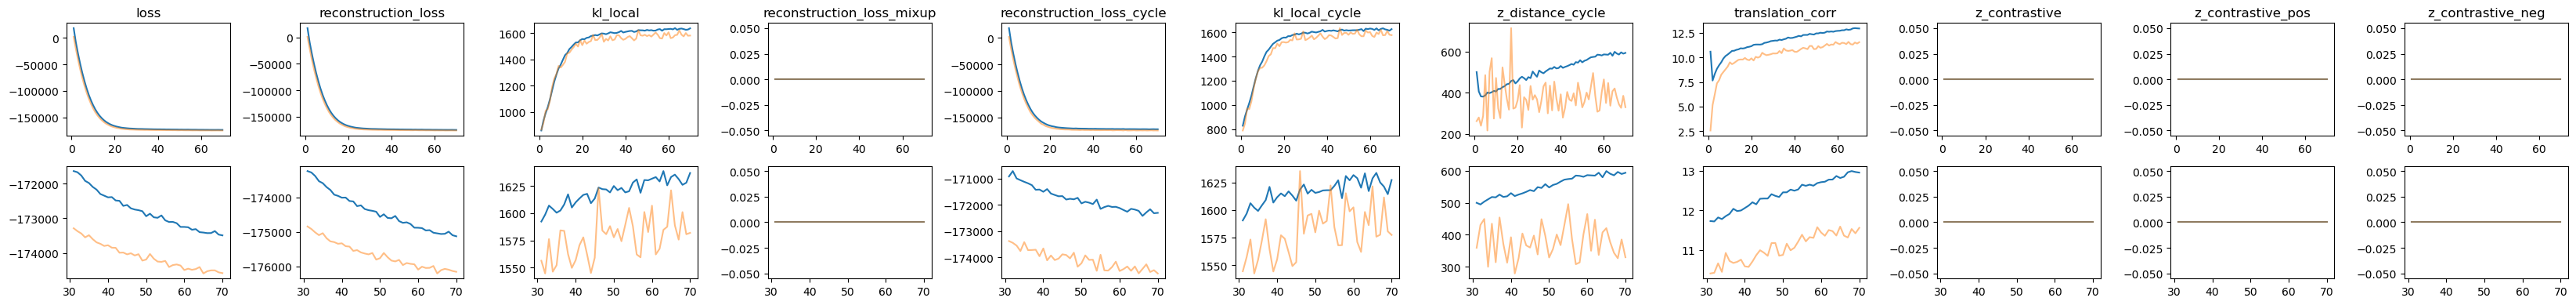

In [44]:
# Plot all loses
losses=[k for k in model.trainer.logger.history.keys() 
        if #'_step' not in k and '_epoch' not in k and 
        ('validation' not in k or 'eval' in k)]
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    l_val=l_train.replace('_train','_validation')
    l_name=l_train.replace('_train','')
    # Change idx of epochs to start with 1 so that below adjustment when 
    # train on step which only works for wal leads to appropriate multiplication
    l_val_values=model.trainer.logger.history[l_val].copy()
    l_val_values.index=l_val_values.index+1
    l_train_values=model.trainer.logger.history[l_train].copy()
    l_train_values.index=l_train_values.index+1
    # This happens if log on step as currently tyhis works only for val loss
    if l_train_values.shape[0]<l_val_values.shape[0]:
        l_train_values.index=\
            l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
    for l_values,c,alpha,dp in [
        # train loss logged on epoch in either case now
        (l_train_values,'tab:blue',1,30),
        (l_val_values,'tab:orange',0.5, 30)]:
        axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
        axs[0,ax_i].set_title(l_name)
        axs[1,ax_i].plot(l_values.index[dp:],
                         l_values.values.ravel()[dp:],c=c,alpha=alpha)

fig.tight_layout()

In [45]:
embed = model.embed(
        adata=adata_training,
        indices=None,
        batch_size=None,
        as_numpy=True)

embed=sc.AnnData(embed,obs=adata_training.obs)

In [46]:
# Use 90 neighbours so that this can be also used for lisi metrics
sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
sc.tl.umap(embed)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterp

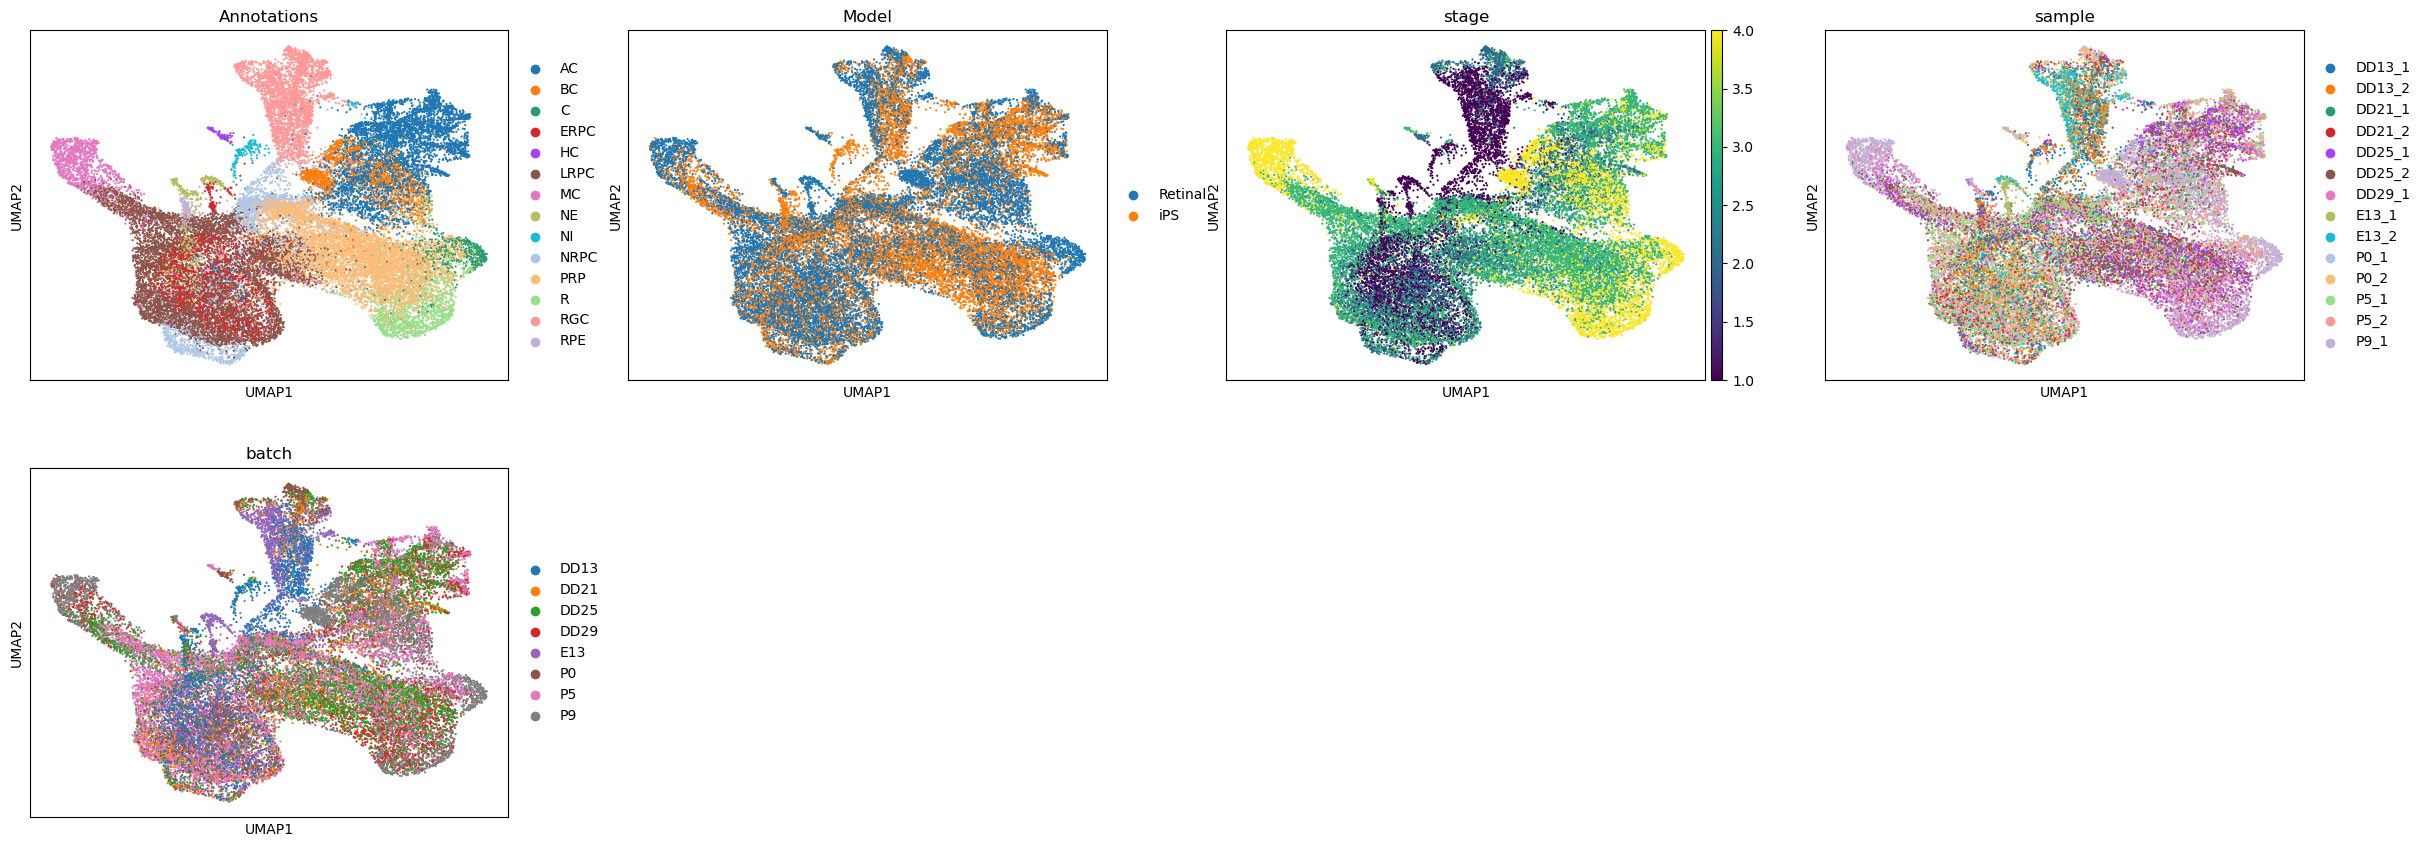

In [47]:
idxs=np.random.permutation(embed.obs_names)
sc.pl.umap(embed[idxs,:],color=['Annotations','Model','stage','sample','batch'],
           s=10,sort_order=False)

## Vamp, no sample batch

In [48]:
adata_training = XXJointModel.setup_anndata(
    adata=adata,
    system_key='system',
    group_key=None,
    categorical_covariate_keys=None,
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


In [49]:
# Train
model = XXJointModel(
    adata=adata_training,
    prior='vamp', 
    n_prior_components=1000,
)
model.train(max_epochs=70,
            log_every_n_steps=1,
            check_val_every_n_epoch=1,
            val_check_interval=1.0,  
            plan_kwargs={
                'loss_weights':{
                   'kl_weight':1,
                   'kl_cycle_weight':0,
                   'reconstruction_weight':1,
                   'reconstruction_mixup_weight':0,
                   'reconstruction_cycle_weight':0,
                   'z_distance_cycle_weight':0,
                   'translation_corr_weight':0,
                   'z_contrastive_weight':0,
               
           }})

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 70/70: 100%|██████████| 70/70 [06:33<00:00,  5.62s/it, loss=-1.35e+03, v_num=1]


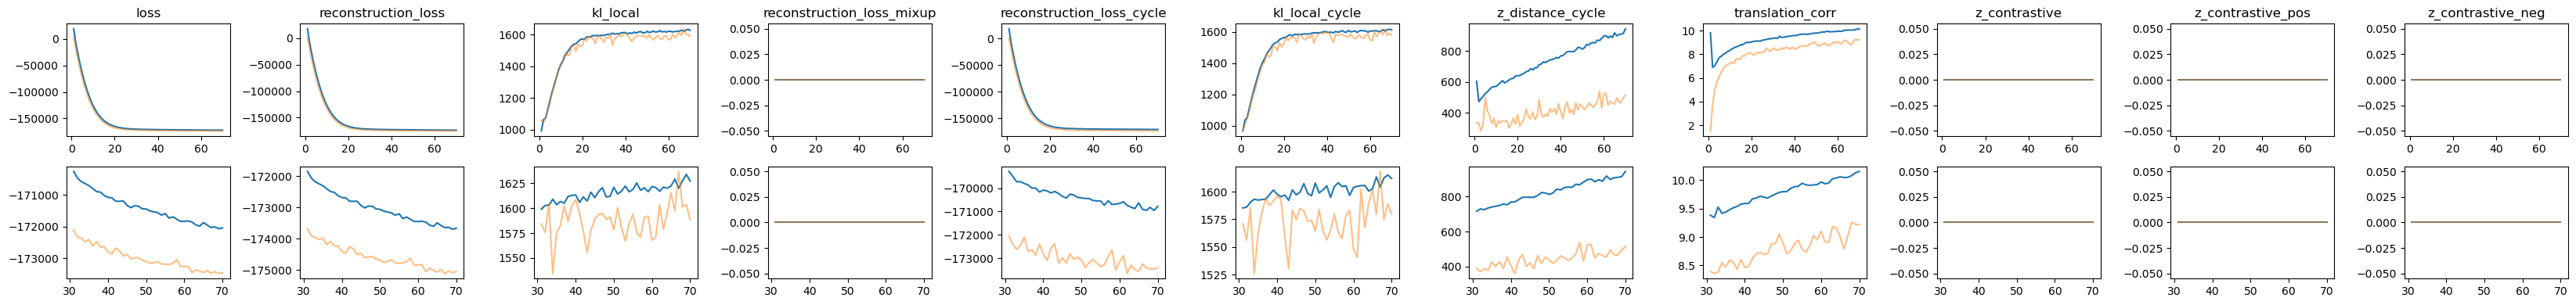

In [50]:
# Plot all loses
losses=[k for k in model.trainer.logger.history.keys() 
        if #'_step' not in k and '_epoch' not in k and 
        ('validation' not in k or 'eval' in k)]
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    l_val=l_train.replace('_train','_validation')
    l_name=l_train.replace('_train','')
    # Change idx of epochs to start with 1 so that below adjustment when 
    # train on step which only works for wal leads to appropriate multiplication
    l_val_values=model.trainer.logger.history[l_val].copy()
    l_val_values.index=l_val_values.index+1
    l_train_values=model.trainer.logger.history[l_train].copy()
    l_train_values.index=l_train_values.index+1
    # This happens if log on step as currently tyhis works only for val loss
    if l_train_values.shape[0]<l_val_values.shape[0]:
        l_train_values.index=\
            l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
    for l_values,c,alpha,dp in [
        # train loss logged on epoch in either case now
        (l_train_values,'tab:blue',1,30),
        (l_val_values,'tab:orange',0.5, 30)]:
        axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
        axs[0,ax_i].set_title(l_name)
        axs[1,ax_i].plot(l_values.index[dp:],
                         l_values.values.ravel()[dp:],c=c,alpha=alpha)

fig.tight_layout()

In [51]:
embed = model.embed(
        adata=adata_training,
        indices=None,
        batch_size=None,
        as_numpy=True)

embed=sc.AnnData(embed,obs=adata_training.obs)

In [52]:
# Use 90 neighbours so that this can be also used for lisi metrics
sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
sc.tl.umap(embed)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterp

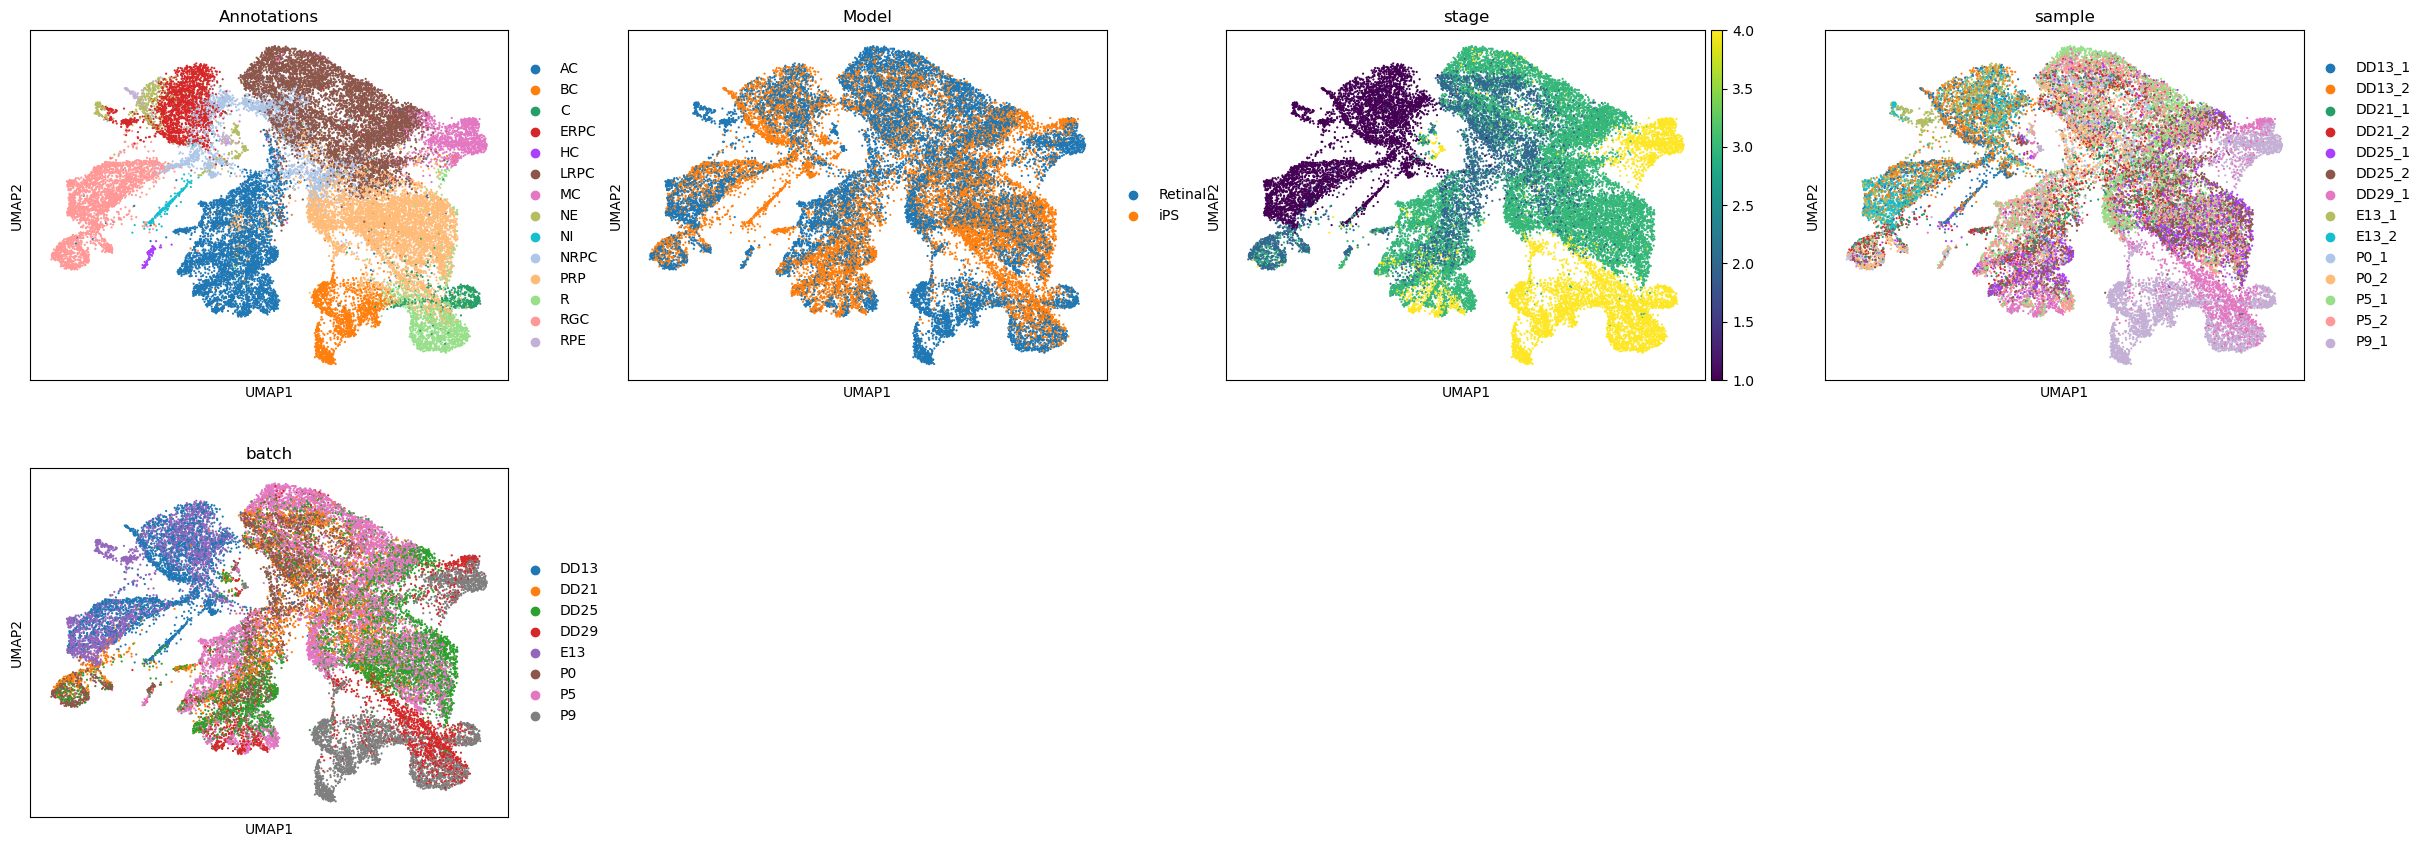

In [53]:
idxs=np.random.permutation(embed.obs_names)
sc.pl.umap(embed[idxs,:],color=['Annotations','Model','stage','sample','batch'],
           s=10,sort_order=False)

C: This integrates so well that unsure if this is even a hard case. Also in paper didnt see integration.

## cVAE, no sample batch

In [54]:
adata_training = XXJointModel.setup_anndata(
    adata=adata,
    system_key='system',
    group_key=None,
    categorical_covariate_keys=None,
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


In [55]:
# Train
model = XXJointModel(
    adata=adata_training,
    prior='standard_normal', 
)
model.train(max_epochs=70,
            log_every_n_steps=1,
            check_val_every_n_epoch=1,
            val_check_interval=1.0,  
            plan_kwargs={
                'loss_weights':{
                   'kl_weight':1,
                   'kl_cycle_weight':0,
                   'reconstruction_weight':1,
                   'reconstruction_mixup_weight':0,
                   'reconstruction_cycle_weight':0,
                   'z_distance_cycle_weight':0,
                   'translation_corr_weight':0,
                   'z_contrastive_weight':0,
               
           }})

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 70/70: 100%|██████████| 70/70 [05:05<00:00,  4.37s/it, loss=-1.35e+03, v_num=1]


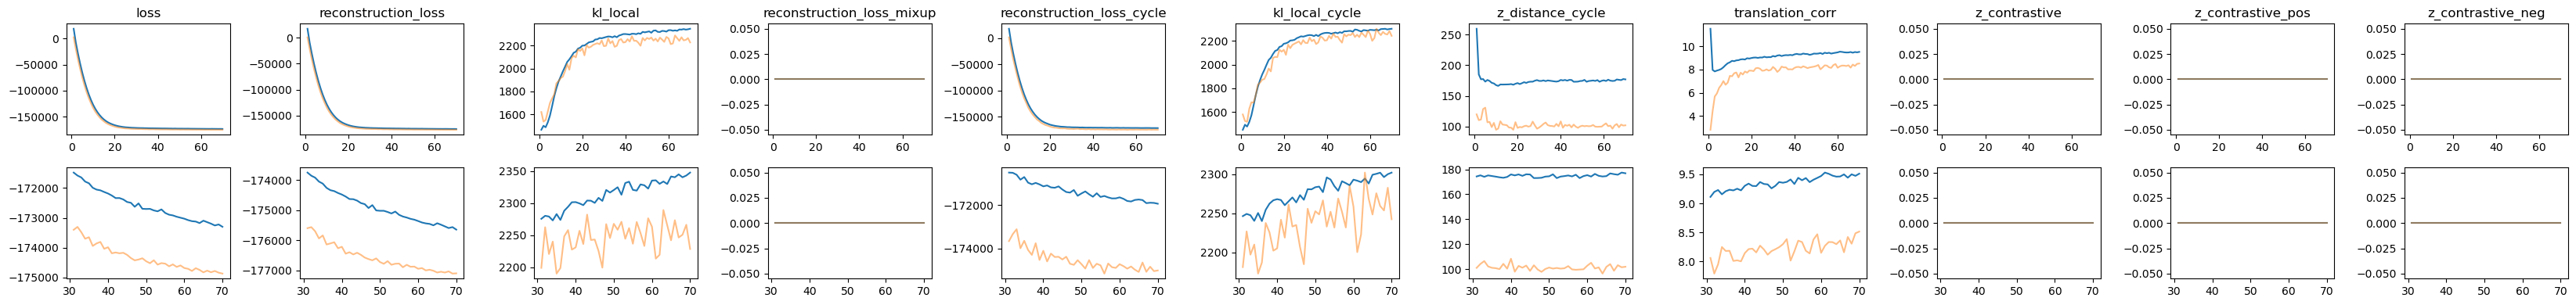

In [56]:
# Plot all loses
losses=[k for k in model.trainer.logger.history.keys() 
        if #'_step' not in k and '_epoch' not in k and 
        ('validation' not in k or 'eval' in k)]
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    l_val=l_train.replace('_train','_validation')
    l_name=l_train.replace('_train','')
    # Change idx of epochs to start with 1 so that below adjustment when 
    # train on step which only works for wal leads to appropriate multiplication
    l_val_values=model.trainer.logger.history[l_val].copy()
    l_val_values.index=l_val_values.index+1
    l_train_values=model.trainer.logger.history[l_train].copy()
    l_train_values.index=l_train_values.index+1
    # This happens if log on step as currently tyhis works only for val loss
    if l_train_values.shape[0]<l_val_values.shape[0]:
        l_train_values.index=\
            l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
    for l_values,c,alpha,dp in [
        # train loss logged on epoch in either case now
        (l_train_values,'tab:blue',1,30),
        (l_val_values,'tab:orange',0.5, 30)]:
        axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
        axs[0,ax_i].set_title(l_name)
        axs[1,ax_i].plot(l_values.index[dp:],
                         l_values.values.ravel()[dp:],c=c,alpha=alpha)

fig.tight_layout()

In [57]:
embed = model.embed(
        adata=adata_training,
        indices=None,
        batch_size=None,
        as_numpy=True)

embed=sc.AnnData(embed,obs=adata_training.obs)

In [58]:
# Use 90 neighbours so that this can be also used for lisi metrics
sc.pp.neighbors(embed, use_rep='X', n_neighbors=90)
sc.tl.umap(embed)

/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/csi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterp

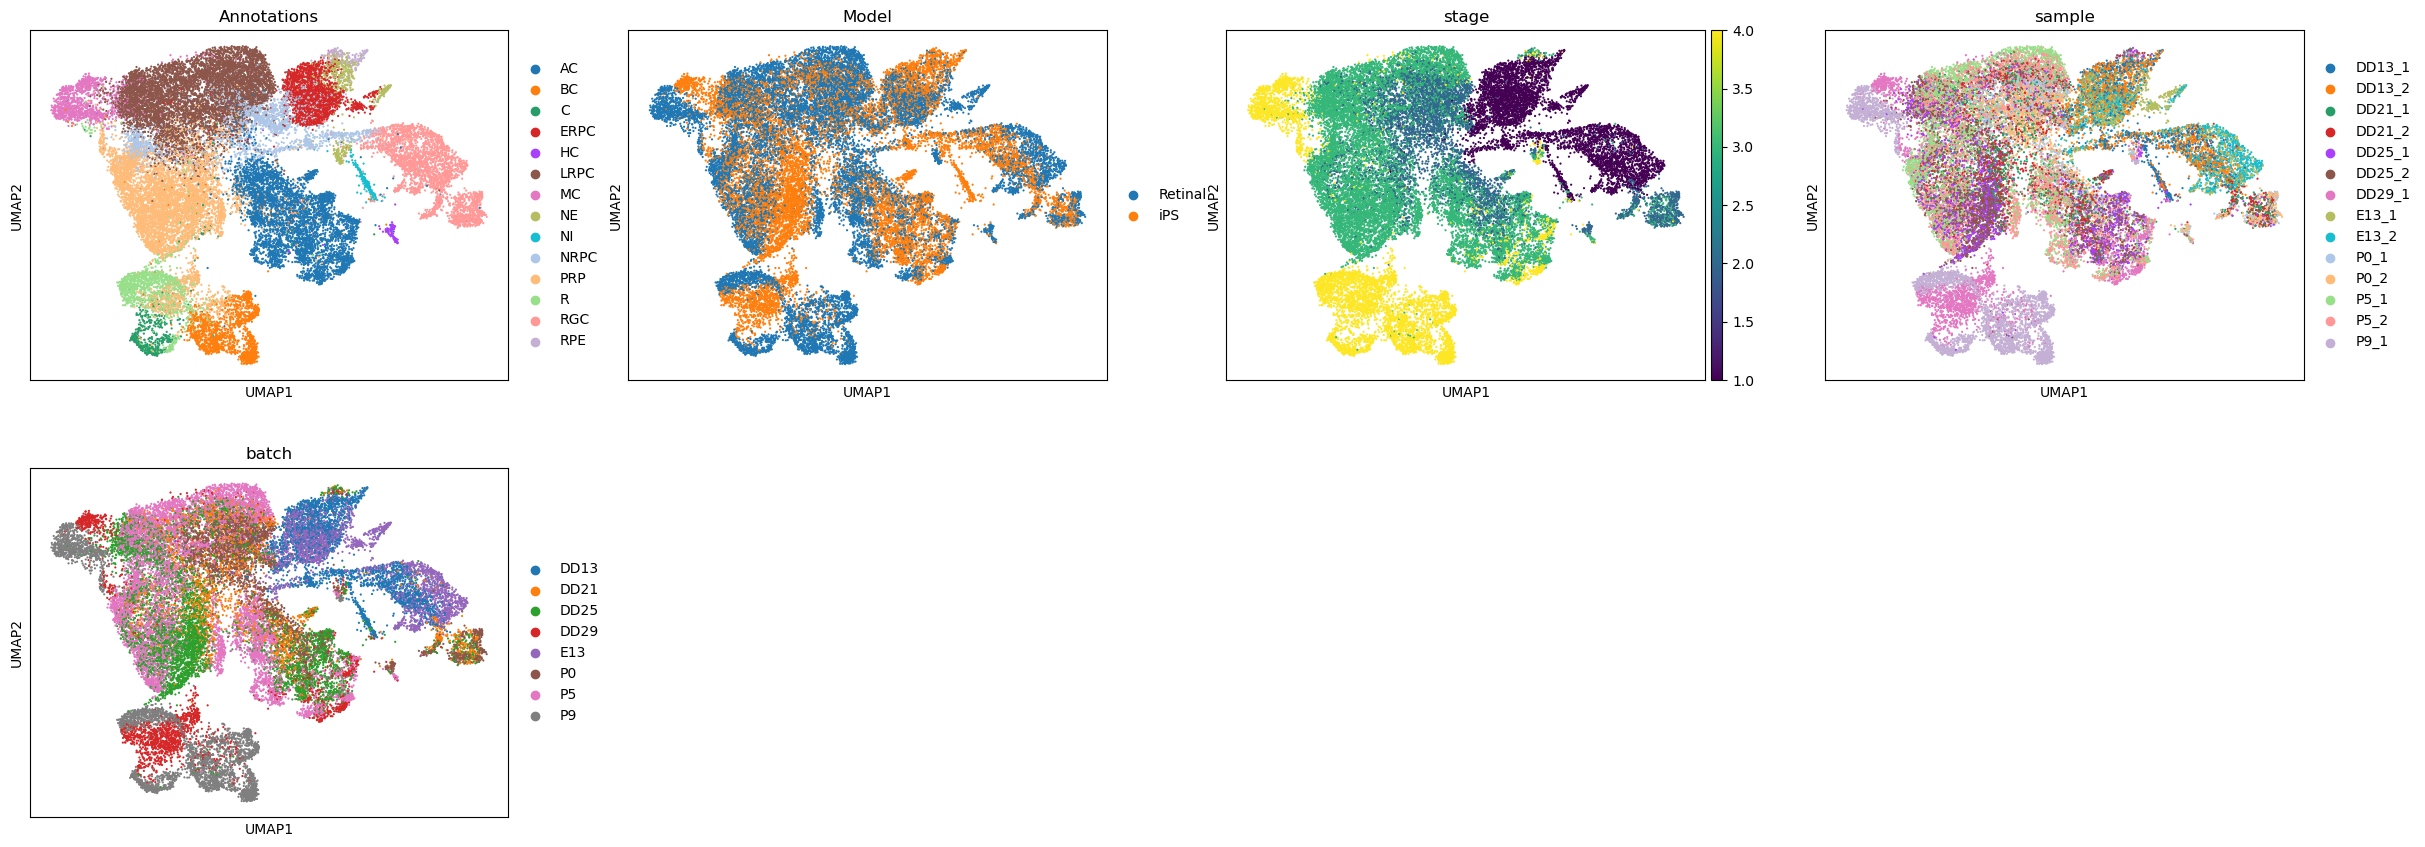

In [59]:
idxs=np.random.permutation(embed.obs_names)
sc.pl.umap(embed[idxs,:],color=['Annotations','Model','stage','sample','batch'],
           s=10,sort_order=False)

C: This dataset may not be the best as even with simple cVAE it integrates quite well. Also annotation was based on integration.